In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import scipy.stats as st
from pathlib import Path
%matplotlib inline


In [20]:
#pull in CSV df - 2019 through 2021 - vehicle csv
csv_path2019 = Path("Resources/vehicle_2019.csv")
csv_path2020 = Path("Resources/vehicle_2020.csv")
csv_path2021 = Path("Resources/vehicle_2021.csv")

vehicle2019_df = pd.read_csv(csv_path2019, encoding='cp1252', low_memory=False)
vehicle2020_df = pd.read_csv(csv_path2020, encoding='cp1252', low_memory=False)
vehicle2021_df = pd.read_csv(csv_path2021, encoding='cp1252', low_memory=False)

#Pull in CSV df - 2019 through 2021 - Person csv
csv2_path2019 = Path("Resources/Person_2019.csv")
csv2_path2020 = Path("Resources/Person_2020.csv")
csv2_path2021 = Path("Resources/Person_2021.csv")

person2019_df = pd.read_csv(csv2_path2019, encoding='cp1252', low_memory=False)
person2020_df = pd.read_csv(csv2_path2020, encoding='cp1252', low_memory=False)
person2021_df = pd.read_csv(csv2_path2021, encoding='cp1252', low_memory=False)

# Extract the "INJ_SEV" and "INJ_SEVNAME" columns from person2019_df
injuries2019_df = person2019_df[['INJ_SEV', 'INJ_SEVNAME']]
injuries2020_df = person2020_df[['INJ_SEV', 'INJ_SEVNAME']]
injuries2021_df = person2021_df[['INJ_SEV', 'INJ_SEVNAME']]

# Add the extracted columns to the fixed DataFrames
vehicle2019_df[['INJ_SEV', 'INJ_SEVNAME']] = injuries2019_df
vehicle2020_df[['INJ_SEV', 'INJ_SEVNAME']] = injuries2020_df
vehicle2021_df[['INJ_SEV', 'INJ_SEVNAME']] = injuries2021_df

#Clean CSV df - 2019 through 2021 - vehicle & person csv
cleaned2019_df = vehicle2019_df[['STATE','STATENAME','MONTHNAME','MONTH','BODY_TYP','DEATHS','ACC_TYPE','OWNER','MAK_MODNAME','HARM_EVNAME', 'MAN_COLLNAME',
                               'VNUM_LAN','INJ_SEV','INJ_SEVNAME']]
cleaned2020_df = vehicle2020_df[['STATE','STATENAME','MONTHNAME','MONTH','BODY_TYP','DEATHS','ACC_TYPE','OWNER','MAK_MODNAME','HARM_EVNAME', 'MAN_COLLNAME',
                               'VNUM_LAN','INJ_SEV','INJ_SEVNAME']]
cleaned2021_df = vehicle2021_df[['STATE','STATENAME','MONTHNAME','MONTH','BODY_TYP','DEATHS','ACC_TYPE','OWNER','MAK_MODNAME','HARM_EVNAME', 'MAN_COLLNAME',
                               'VNUM_LAN','INJ_SEV','INJ_SEVNAME']]


# Renaming columns and filtering them
new_names = {"HARM_EVNAME": "Accident Type", "MAN_COLLNAME": "Vehicle Crash Description", "VNUM_LAN": "Lanes Involved",
             "BODY_TYP": "Vehicle Type ID", "STATENAME": "State Name", "MONTHNAME": "Month Name", "MONTH": "Month", "BODY_TYPNAME": "Body Type",
             "DEATHS":"Deaths", "OWNER": "Owner", "MAK_MODNAME": "Make and Model","INJ_SEV": "Injury ID","INJ_SEVNAME":"Injury Type"}
fixed2019_df = cleaned2019_df.rename(columns=new_names)
fixed2020_df = cleaned2020_df.rename(columns=new_names)
fixed2021_df = cleaned2021_df.rename(columns=new_names)

# Filters by potential lane splitting or filtering motorcycles exclusively
filtered2019_df = fixed2019_df[(fixed2019_df['Vehicle Type ID'].between(80, 87)) & (fixed2019_df['Lanes Involved'] != 1)]
filtered2020_df = fixed2020_df[(fixed2020_df['Vehicle Type ID'].between(80, 87)) & (fixed2020_df['Lanes Involved'] != 1)]
filtered2021_df = fixed2021_df[(fixed2021_df['Vehicle Type ID'].between(80, 87)) & (fixed2021_df['Lanes Involved'] != 1)]

In [21]:
# Filter the dataframes for each year for appropriate columns

df_list = [filtered2019_df, filtered2020_df, filtered2021_df]

filtered_df_list=[]

for df in df_list:

    cleaned_df = df[['STATE','State Name','Injury ID', 'Injury Type','Vehicle Type ID','Month Name','Month','Deaths','Owner']]
    motorcycle_df = cleaned_df.loc[cleaned_df['Vehicle Type ID'].between(80, 87)]
    summer_df = motorcycle_df.loc[(motorcycle_df['Month'] >= 4) & (motorcycle_df['Month'] <= 8)]
    final_filter_df = summer_df.loc[(summer_df['Owner'] != 0) & (summer_df['Deaths'] > 0)]

    filtered_df_list.append(final_filter_df)

In [23]:
# add filtered data frames to law groups for all years:

legal_group = []
somewhat_legal_group = []
not_mentioned_group = []
illegal_group = []


for df in filtered_df_list:
    legal_df = df.loc[(df['State Name']== "California")]
 
    somewhat_legal_df = df.loc[df['State Name'].isin(["Utah","Hawaii"])]
                                  
    not_mentioned_df = df.loc[df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                        "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                        "North Carolina", "West Virgina", "Delaware","Mississippi"])]                      

    illegal_df = df.loc[~df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                "North Carolina", "West Virgina", "Delaware","Mississippi",
                                                "California","Utah","Hawaii", "Total"])] 

    legal_group.append(legal_df)
    somewhat_legal_group.append(somewhat_legal_df)
    not_mentioned_group.append(not_mentioned_df)
    illegal_group.append(illegal_df)

In [25]:
# Group by 'State Name' and count the occurrences of 'Injury Type' for each state
injuries_count_2019_df = filtered2019_df.groupby('State Name')['Injury Type'].value_counts()
injuries_count_2020_df = filtered2020_df.groupby('State Name')['Injury Type'].value_counts()
injuries_count_2021_df = filtered2021_df.groupby('State Name')['Injury Type'].value_counts()

# Convert the Series to a DataFrame and reset the index
injuries_count_2019_df = injuries_count_2019_df.reset_index(name='Count')
injuries_count_2020_df = injuries_count_2020_df.reset_index(name='Count')
injuries_count_2021_df = injuries_count_2021_df.reset_index(name='Count')

# Calculate the total count of Injury Type for each state
total_count_by_state_2019_df = injuries_count_2019_df.groupby('State Name')['Count'].sum().reset_index(name='Total Count')
total_count_by_state_2020_df = injuries_count_2020_df.groupby('State Name')['Count'].sum().reset_index(name='Total Count')
total_count_by_state_2021_df = injuries_count_2021_df.groupby('State Name')['Count'].sum().reset_index(name='Total Count')

# Merge the total count with the existing DataFrame
injuries_count_2019_df = injuries_count_2019_df.merge(total_count_by_state_2019_df, on='State Name')
injuries_count_2020_df = injuries_count_2020_df.merge(total_count_by_state_2020_df, on='State Name')
injuries_count_2021_df = injuries_count_2021_df.merge(total_count_by_state_2021_df, on='State Name')

In [26]:
#clean data for CA (Legal) -  years 2019 through 2021 
legal_2019_df = injuries_count_2019_df[(injuries_count_2019_df['State Name']== "California")]
legal_2020_df = injuries_count_2020_df[(injuries_count_2020_df['State Name']== "California")]
legal_2021_df = injuries_count_2021_df[(injuries_count_2021_df['State Name']== "California")]

#clean data for (Somewhat Legal) - years 2019 through 2021
somewhat_legal_2019_df = injuries_count_2019_df[injuries_count_2019_df['State Name'].isin(["Utah","Hawaii"])] 
somewhat_legal_2020_df = injuries_count_2020_df[injuries_count_2020_df['State Name'].isin(["Utah","Hawaii"])]  
somewhat_legal_2021_df = injuries_count_2021_df[injuries_count_2021_df['State Name'].isin(["Utah","Hawaii"])]

#clean data for (Illegal) - years 2019 through 2021 
illegal_2019_df = injuries_count_2019_df[injuries_count_2019_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                  "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                  "North Carolina", "West Virgina", "Delaware","Mississippi"])]
illegal_2020_df = injuries_count_2020_df[injuries_count_2020_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                  "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                  "North Carolina", "West Virgina", "Delaware","Mississippi"])]
illegal_2021_df = injuries_count_2021_df[injuries_count_2021_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                  "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                  "North Carolina", "West Virgina", "Delaware","Mississippi"])]
#clean data for (Not Mentioned) - years 2019 through 2021 
not_mentioned_2019_df = injuries_count_2019_df[~injuries_count_2019_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                  "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                  "North Carolina", "West Virgina", "Delaware","Mississippi",
                                                                  "California","Utah","Hawaii", "Total"])] 
not_mentioned_2020_df = injuries_count_2020_df[~injuries_count_2020_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                  "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                  "North Carolina", "West Virgina", "Delaware","Mississippi",
                                                                  "California","Utah","Hawaii", "Total"])]
not_mentioned_2021_df = injuries_count_2021_df[~injuries_count_2021_df['State Name'].isin(["Montana", "New Mexico", "Texas", "Oklahoma",
                                                                  "Missouri", "Arkansas", "Ohio", "Kentucky",
                                                                  "North Carolina", "West Virgina", "Delaware","Mississippi",
                                                                  "California","Utah","Hawaii", "Total"])]

illegal_2019_df.head()

,State Name,Injury Type,Count,Total Count
16,Arkansas,Fatal Injury (K),31,65
17,Arkansas,Suspected Minor Injury (B),10,65
18,Arkansas,No Apparent Injury (O),10,65
19,Arkansas,Suspected Serious Injury (A),6,65
20,Arkansas,Possible Injury (C),5,65


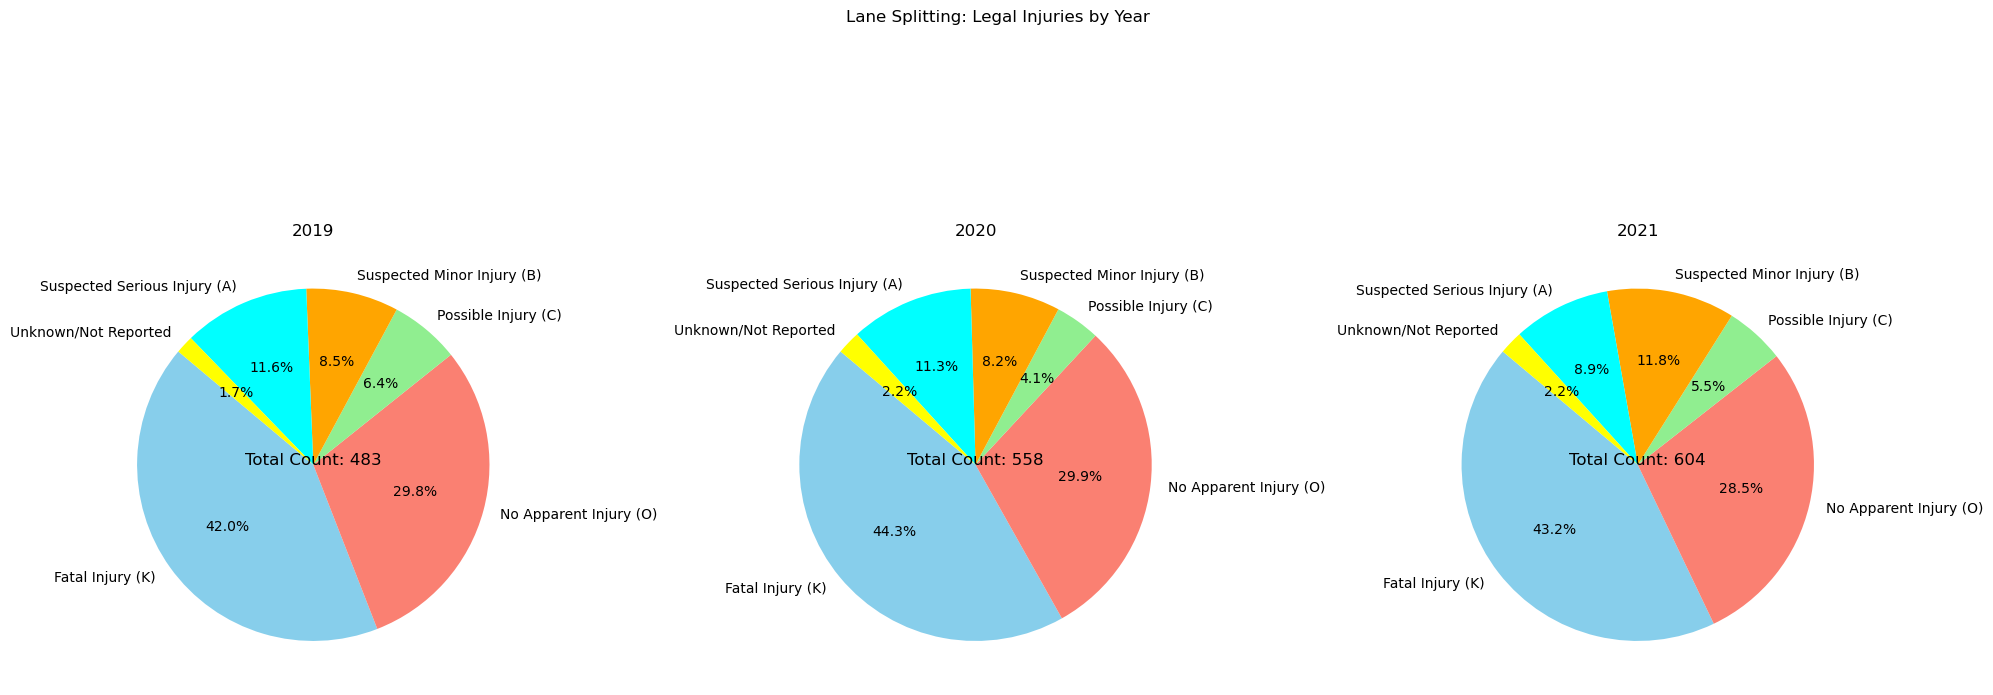

In [30]:
# Group the data by "Injury Type", and calculate the total count for each injury type
legal_injury_chart_2019 = legal_2019_df .groupby(["Injury Type"])["Count"].sum()
legal_injury_chart_2020 = legal_2020_df .groupby(["Injury Type"])["Count"].sum()
legal_injury_chart_2021 = legal_2021_df .groupby(["Injury Type"])["Count"].sum()

# Create subplots for each year
plt.figure(figsize=(20, 8))

# 2019 Pie Chart
plt.subplot(1, 3, 1)
wedges, texts, autotexts = plt.pie(legal_injury_chart_2019, labels=legal_injury_chart_2019.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow'])
total_count = legal_injury_chart_2019.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2019')

# 2020 Pie Chart
plt.subplot(1, 3, 2)
wedges, texts, autotexts = plt.pie(legal_injury_chart_2020, labels=legal_injury_chart_2020.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow'])
total_count = legal_injury_chart_2020.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2020')

# 2021 Pie Chart
plt.subplot(1, 3, 3)
wedges, texts, autotexts = plt.pie(legal_injury_chart_2021, labels=legal_injury_chart_2021.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow'])
total_count = legal_injury_chart_2021.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2021')

plt.suptitle(f'Lane Splitting: Legal Injuries by Year', y=1.05)
plt.tight_layout()

plt.show()

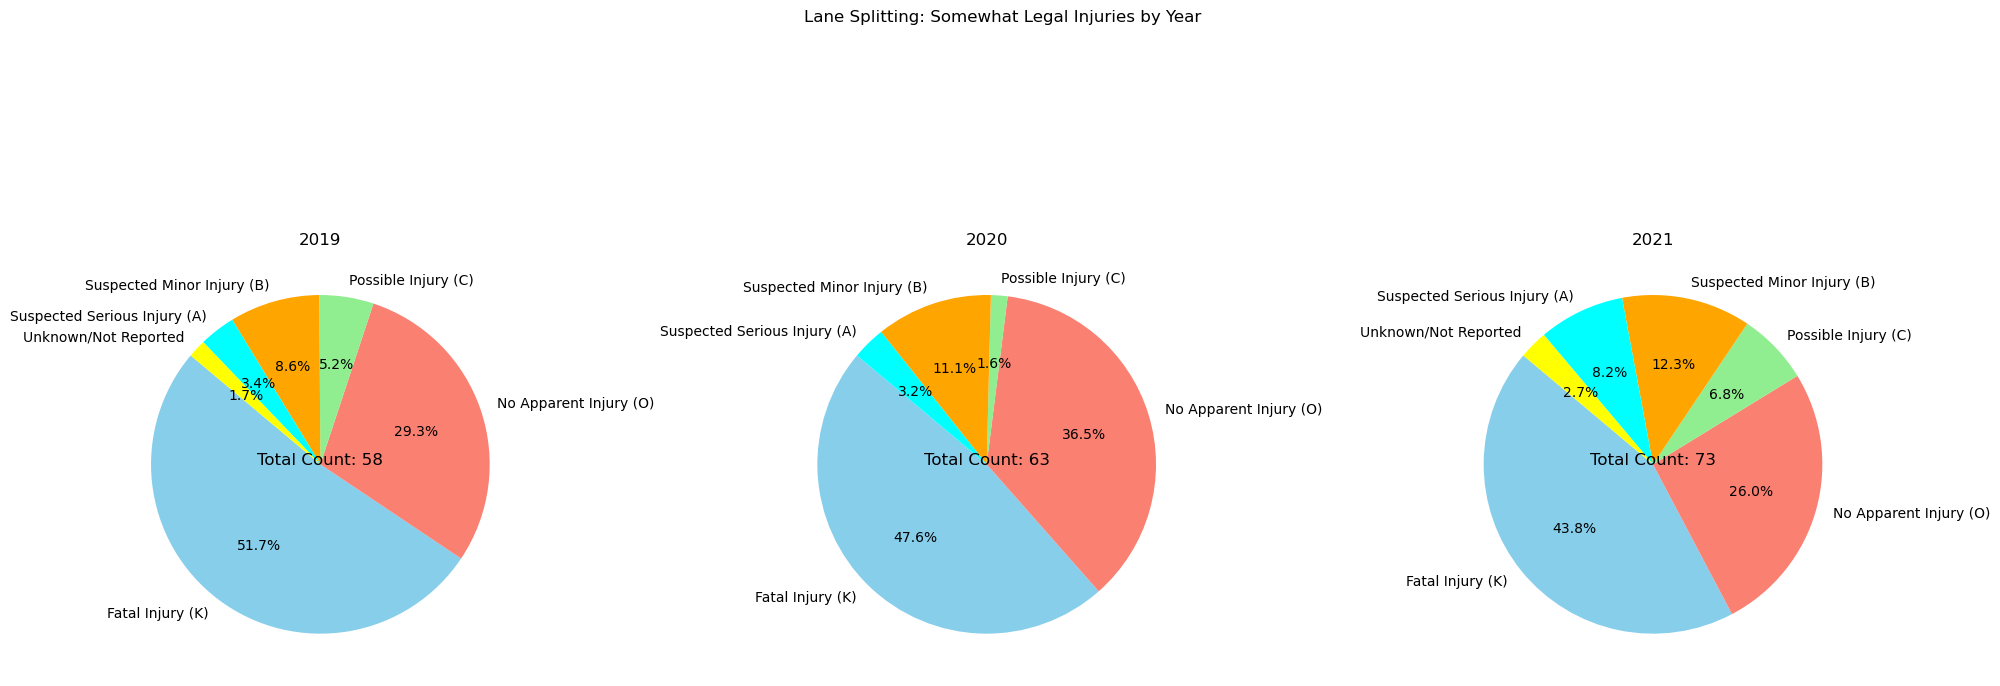

In [28]:
# Group the data by "Injury Type", and calculate the total count for each injury type
somewhat_injury_chart_2019 = somewhat_legal_2019_df.groupby("Injury Type")["Count"].sum()
somewhat_injury_chart_2020 = somewhat_legal_2020_df.groupby("Injury Type")["Count"].sum()
somewhat_injury_chart_2021 = somewhat_legal_2021_df.groupby("Injury Type")["Count"].sum()

# Create subplots for each year
plt.figure(figsize=(20, 8))

# 2019 Pie Chart
plt.subplot(1, 3, 1)
wedges, texts, autotexts = plt.pie(somewhat_injury_chart_2019, labels=somewhat_injury_chart_2019.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow'])
total_count = somewhat_injury_chart_2019.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2019')

# 2020 Pie Chart
plt.subplot(1, 3, 2)
wedges, texts, autotexts = plt.pie(somewhat_injury_chart_2020, labels=somewhat_injury_chart_2020.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow'])
total_count = somewhat_injury_chart_2020.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2020')

# 2021 Pie Chart
plt.subplot(1, 3, 3)
wedges, texts, autotexts = plt.pie(somewhat_injury_chart_2021, labels=somewhat_injury_chart_2021.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow'])
total_count = somewhat_injury_chart_2021.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2021')

plt.suptitle(f'Lane Splitting: Somewhat Legal Injuries by Year', y=1.05)
plt.tight_layout()

plt.show()



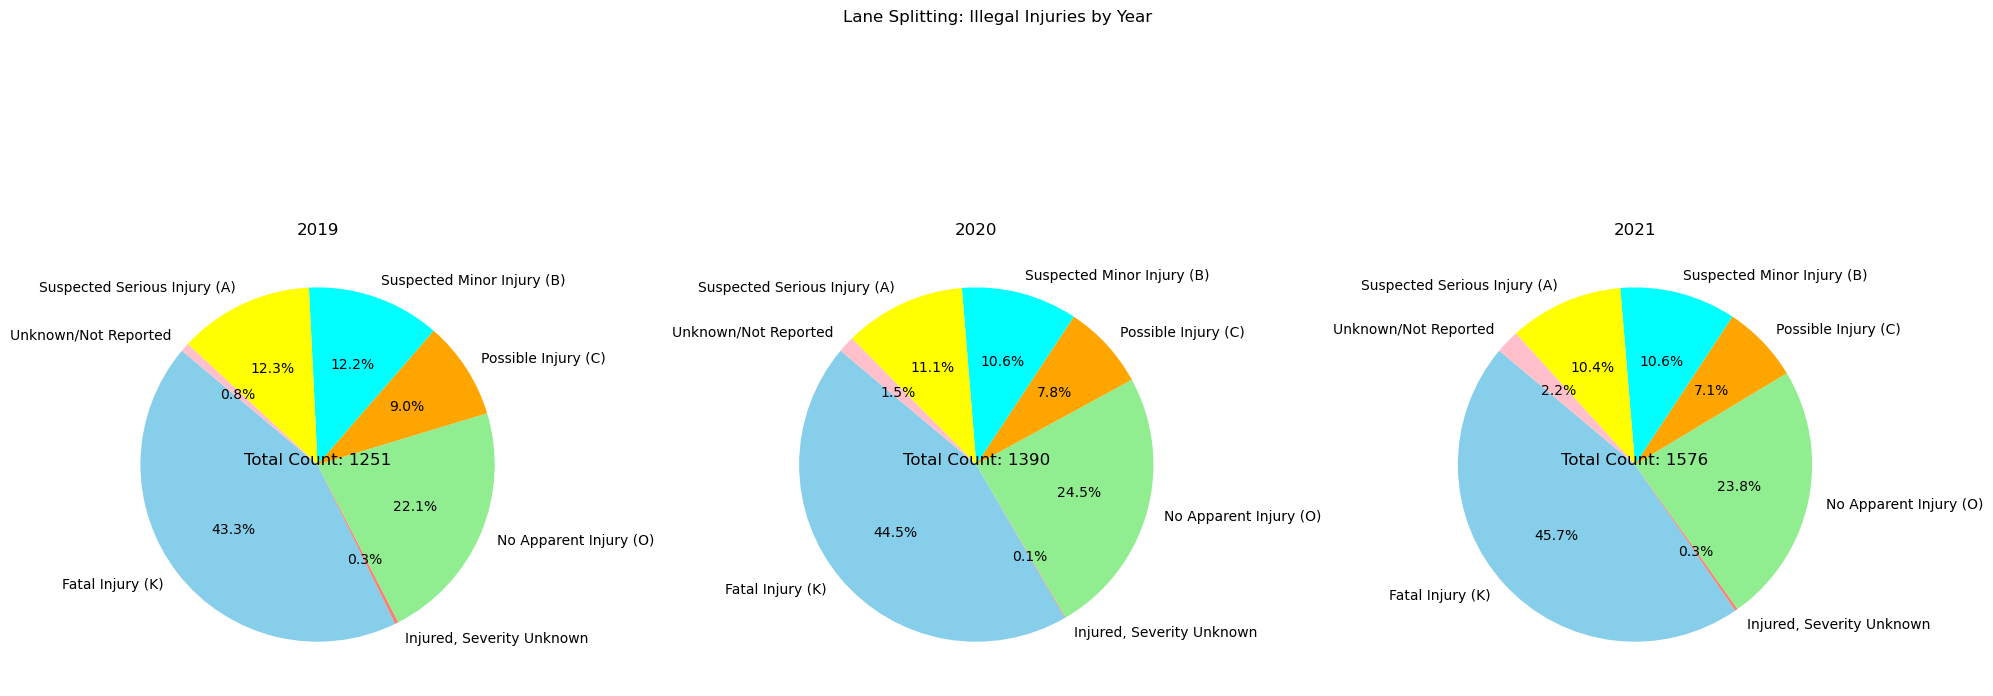

In [60]:
# Group the data by "Injury Type", and calculate the total count for each injury type
illegal_injury_chart_2019 = illegal_2019_df.groupby("Injury Type")["Count"].sum()
illegal_injury_chart_2020 = illegal_2020_df.groupby("Injury Type")["Count"].sum()
illegal_injury_chart_2021 = illegal_2021_df.groupby("Injury Type")["Count"].sum()

# Create subplots for each year
plt.figure(figsize=(20, 8))

# 2019 Pie Chart
plt.subplot(1, 3, 1)
wedges, texts, autotexts = plt.pie(illegal_injury_chart_2019, labels=illegal_injury_chart_2019.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow','pink'])
total_count = illegal_injury_chart_2019.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2019')

# 2020 Pie Chart
plt.subplot(1, 3, 2)
wedges, texts, autotexts = plt.pie(illegal_injury_chart_2020, labels=illegal_injury_chart_2020.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow','pink'])
total_count = illegal_injury_chart_2020.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2020')

# 2021 Pie Chart
plt.subplot(1, 3, 3)
wedges, texts, autotexts = plt.pie(illegal_injury_chart_2021, labels=illegal_injury_chart_2021.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow','pink'])
total_count = illegal_injury_chart_2021.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2021')

plt.suptitle(f'Lane Splitting: Illegal Injuries by Year', y=1.05)
plt.tight_layout()

plt.show()

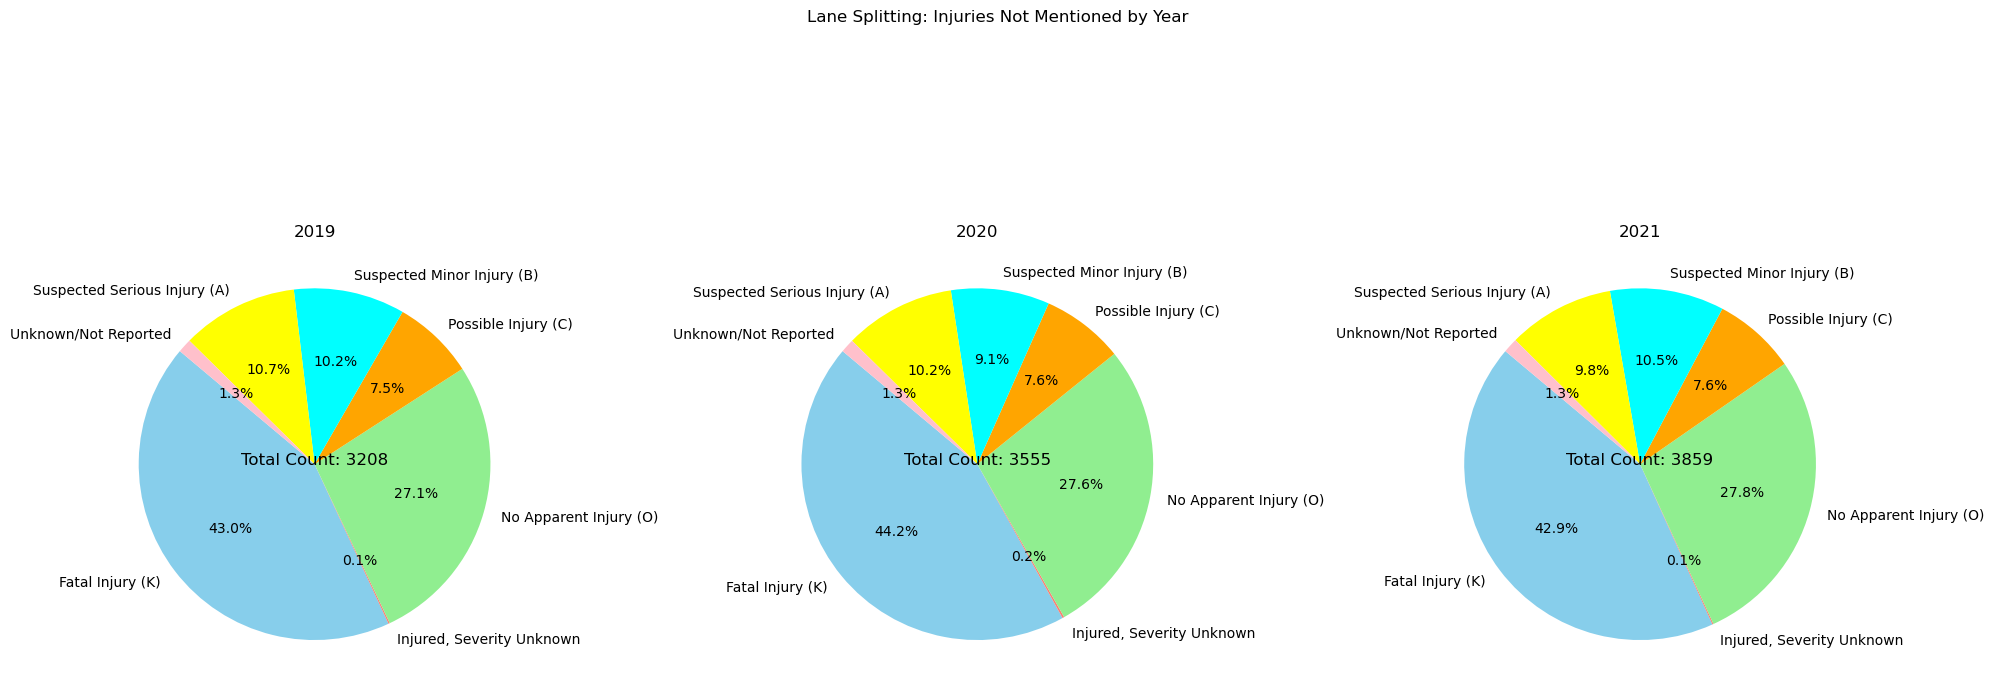

In [29]:
# Group the data by "Injury Type", and calculate the total count for each injury type
not_mentioned_injury_chart_2019 = not_mentioned_2019_df.groupby("Injury Type")["Count"].sum()
not_mentioned_injury_chart_2020 = not_mentioned_2020_df.groupby("Injury Type")["Count"].sum()
not_mentioned_injury_chart_2021 = not_mentioned_2021_df.groupby("Injury Type")["Count"].sum()

# Create subplots for each year
plt.figure(figsize=(20,8))

# 2019 Pie Chart
plt.subplot(1, 3, 1)
wedges, texts, autotexts = plt.pie(not_mentioned_injury_chart_2019, labels=not_mentioned_injury_chart_2019.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow','pink'])
total_count = not_mentioned_injury_chart_2019.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2019')

# 2020 Pie Chart
plt.subplot(1, 3, 2)
wedges, texts, autotexts = plt.pie(not_mentioned_injury_chart_2020, labels=not_mentioned_injury_chart_2020.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow','pink'])
total_count = not_mentioned_injury_chart_2020.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2020')

# 2021 Pie Chart
plt.subplot(1, 3, 3)
wedges, texts, autotexts = plt.pie(not_mentioned_injury_chart_2021, labels=not_mentioned_injury_chart_2021.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon', 'lightgreen', 'orange','aqua','yellow','pink'])
total_count = not_mentioned_injury_chart_2021.sum()
plt.text(0, 0, f'Total Count: {total_count}', color='black', fontsize=12, ha='center')
plt.title('2021')

plt.suptitle(f'Lane Splitting: Injuries Not Mentioned by Year', y=1.05)
plt.tight_layout()

plt.show()